# Traffic Network Generator

In [1]:
# import the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from itertools import combinations, groupby
import networkx as nx
import random
import pickle

## Graph generation

In [2]:
# randomly connected graph generator
def gnp_random_connected_graph(n, p):
    edges = combinations(['n'+str(i) for i in range(n)], 2)
    G = nx.Graph()
    G.add_nodes_from(['n'+str(i) for i in range(n)])
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

### Creating graph

In [3]:
# create graph
nodes = 70
seed = random.randint(1,10)
probability = .0075


G = gnp_random_connected_graph(nodes, probability)
### Border nodes
#add a node attribute that stores wheter the node is a border node or not, aka if it has only one neighbor
for node in G.nodes():
    G.nodes[node]['border'] = (len(list(G.neighbors(node))) == 1)

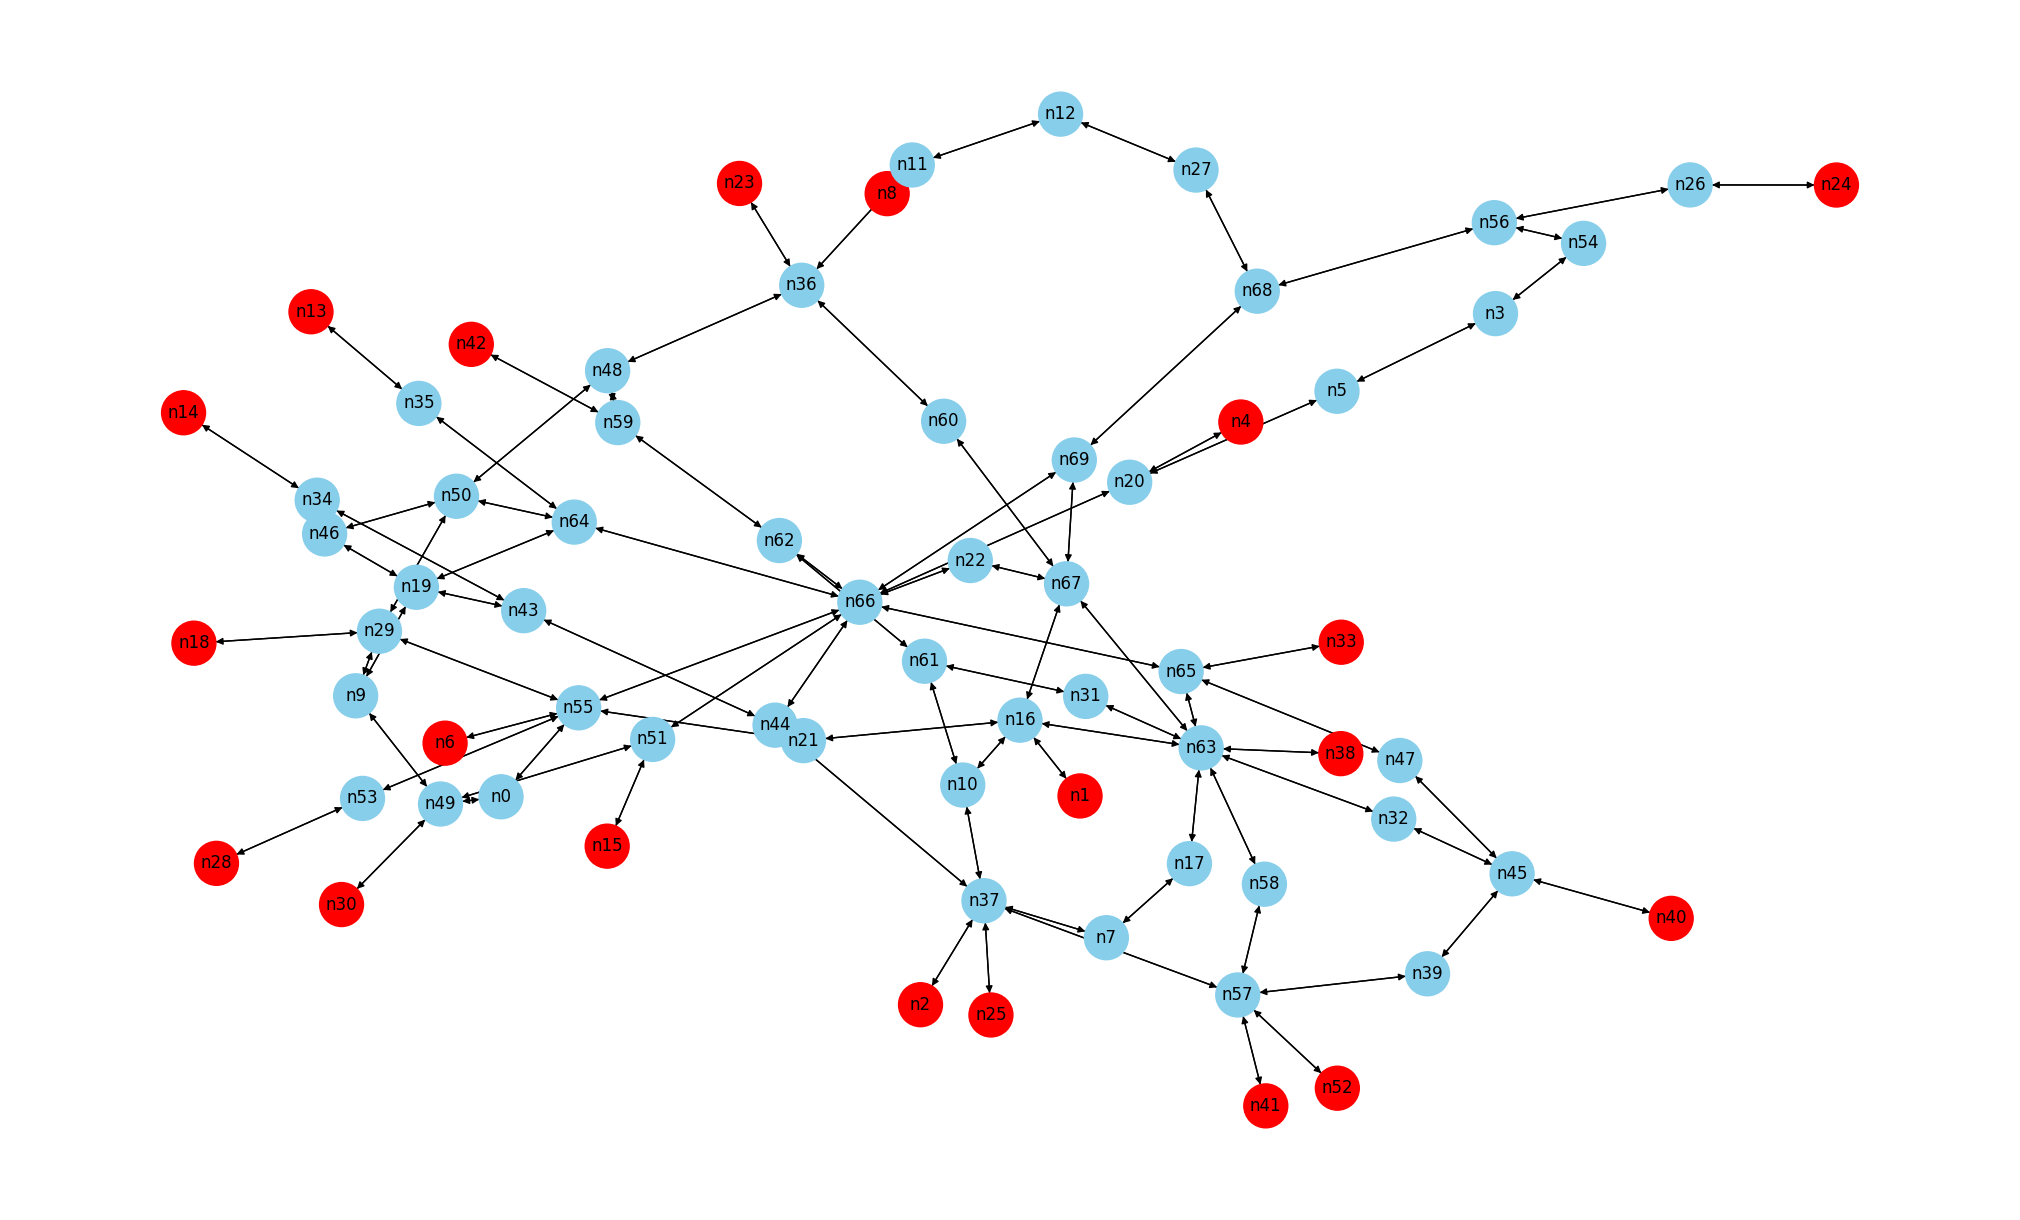

In [4]:
#make the graph directed, and duplicate the edges in the opposite direction
G = G.to_directed()
G.add_edges_from([(v,u) for u,v in G.edges()])
plt.figure(figsize=(20,12))
pos = nx.spring_layout(G)
nx.draw(G, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), with_labels=True, node_size=1000, node_shape="o", pos=pos)

In [5]:
#check the number of border nodes
print("Number of border nodes: ", len([node for node in G.nodes() if G.nodes[node]['border']]), len([node for node in G.nodes() if G.nodes[node]['border']])/len(G.nodes())*100, "%")

Number of border nodes:  20 28.57142857142857 %


## Flow generation

In [6]:
#each edge needs to have 3 values: The lanes, trafiic, and whether it is a border edge
for u,v in G.edges():
    if (int(u[1:]) > int(v[1:])):
        continue
    #for lanes, follow this probability distribution: 1 - .3, 2 - .4, 3 - .05, 4 - .1, 5 - .05, 6 - .2
    G.edges[u,v]['lanes'] = np.random.choice([1,2,3,4,5,6], p=[.3,.4,.05,.1,.05,.1])
    #make sure the opposite edge has the same number of lanes
    G.edges[v,u]['lanes'] = G.edges[u,v]['lanes']

    #generate a random number between 0 and 100 for traffic
    G.edges[u,v]['traffic'] = float(random.randint(0,100))
    G.edges[v,u]['traffic'] = float(random.randint(0,100))

    #set the border attribute
    G.edges[u,v]['border'] = G.nodes[u]['border'] or G.nodes[v]['border']
    G.edges[v,u]['border'] = G.nodes[u]['border'] or G.nodes[v]['border']

    #print the edge data
    print(u,v,G.edges[u,v], G.edges[v,u])

n0 n55 {'lanes': 2, 'traffic': 96.0, 'border': False} {'lanes': 2, 'traffic': 72.0, 'border': False}
n0 n49 {'lanes': 2, 'traffic': 37.0, 'border': False} {'lanes': 2, 'traffic': 5.0, 'border': False}
n1 n16 {'lanes': 2, 'traffic': 91.0, 'border': True} {'lanes': 2, 'traffic': 19.0, 'border': True}
n2 n37 {'lanes': 1, 'traffic': 87.0, 'border': True} {'lanes': 1, 'traffic': 65.0, 'border': True}
n3 n54 {'lanes': 2, 'traffic': 9.0, 'border': False} {'lanes': 2, 'traffic': 38.0, 'border': False}
n3 n5 {'lanes': 6, 'traffic': 20.0, 'border': False} {'lanes': 6, 'traffic': 62.0, 'border': False}
n4 n20 {'lanes': 5, 'traffic': 33.0, 'border': True} {'lanes': 5, 'traffic': 46.0, 'border': True}
n5 n20 {'lanes': 2, 'traffic': 25.0, 'border': False} {'lanes': 2, 'traffic': 39.0, 'border': False}
n6 n55 {'lanes': 2, 'traffic': 37.0, 'border': True} {'lanes': 2, 'traffic': 70.0, 'border': True}
n7 n17 {'lanes': 5, 'traffic': 99.0, 'border': False} {'lanes': 5, 'traffic': 16.0, 'border': False}
n

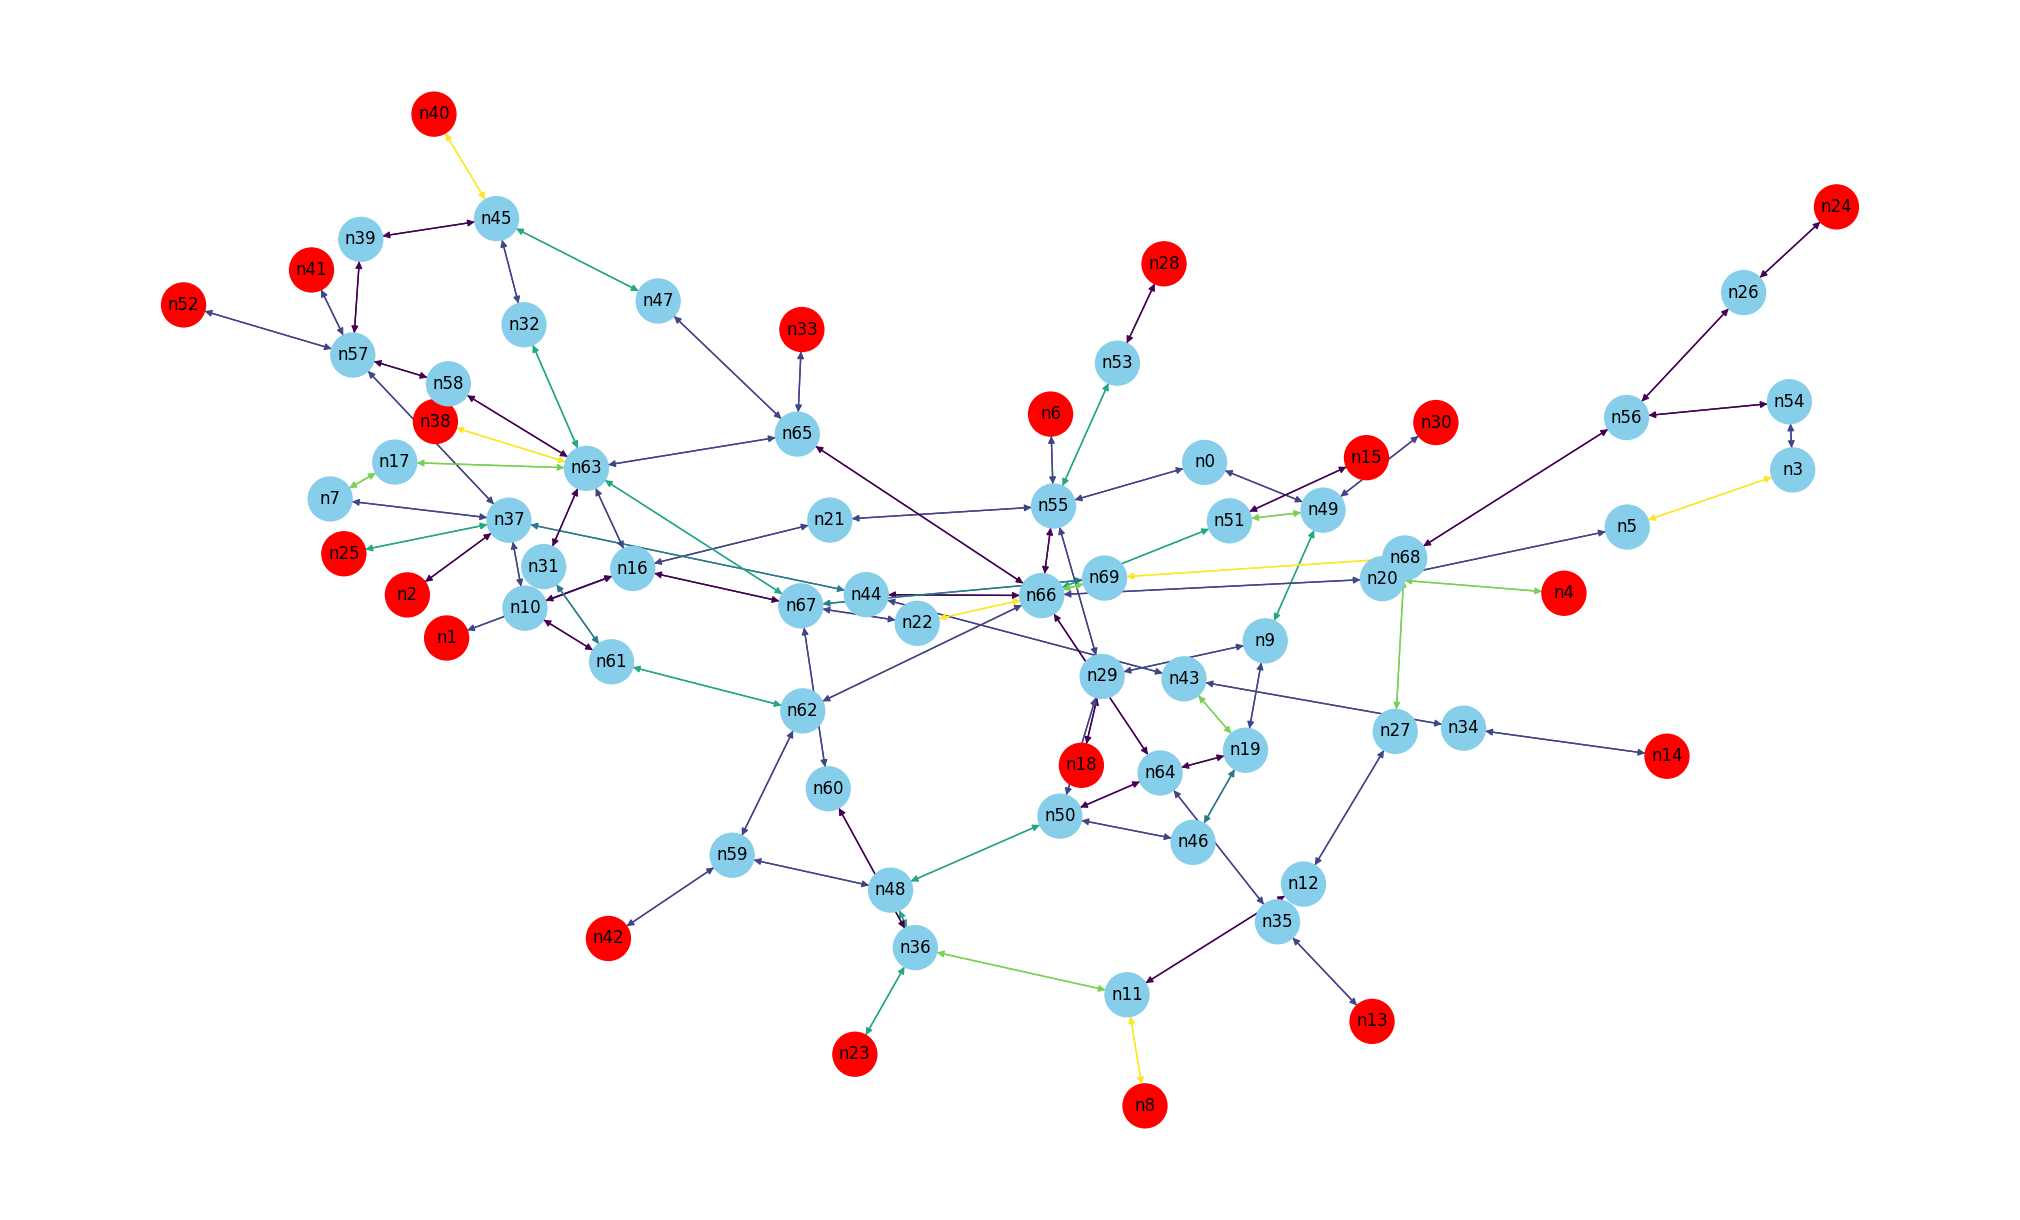

In [7]:
#plot the graph, coloring the edges based on the number of lanes
plt.figure(figsize=(20,12))
nx.draw(G, with_labels=True, node_size=1000, node_shape="o", edge_color=[G.edges[edge]['lanes'] for edge in G.edges], node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'))

In [8]:
#add node attributes for the traffic into and out of a node
for node in G.nodes():
    G.nodes[node]['traffic_in'] = sum([(G.edges[edge]['traffic'] * G.edges[edge]['lanes']) for edge in G.in_edges(node)])
    G.nodes[node]['traffic_out'] = sum([(G.edges[edge]['traffic'] * G.edges[edge]['lanes']) for edge in G.out_edges(node)])
    G.nodes[node]['traffic'] = G.nodes[node]['traffic_in'] + G.nodes[node]['traffic_out']
    #also track the number of lanes in and out of a node
    G.nodes[node]['lanes_in'] = sum([G.edges[edge]['lanes'] for edge in G.in_edges(node)])
    G.nodes[node]['lanes_out'] = sum([G.edges[edge]['lanes'] for edge in G.out_edges(node)])
    #add a flag for whether any of the edges are border edges
    G.nodes[node]['borderedge'] = any([G.edges[edge]['border'] for edge in G.edges(node)])
    #store the border_in and border_out values
    G.nodes[node]['border_in'] = sum([(G.edges[edge]['traffic'] * G.edges[edge]['lanes']) for edge in G.in_edges(node) if G.edges[edge]['border']])
    G.nodes[node]['border_out'] = sum([(G.edges[edge]['traffic'] * G.edges[edge]['lanes']) for edge in G.out_edges(node) if G.edges[edge]['border']])
    G.nodes[node]['border_in_lanes'] = sum([G.edges[edge]['lanes'] for edge in G.in_edges(node) if G.edges[edge]['border']])
    G.nodes[node]['border_out_lanes'] = sum([G.edges[edge]['lanes'] for edge in G.out_edges(node) if G.edges[edge]['border']])

In [9]:
#save the graph
with open('graph1.gpickle', 'wb') as f:
    pickle.dump(G, f)

## Linear Graph Generation

In [10]:
#we can use the earlier graph to generate a new graph with the same nodes and edges, but with different traffic values
#in this case, the inital graph need to have the same traffic values in each direction for each edge
G2 = G.copy()

In [11]:
#add the traffic values
#we will randomize the traffic value on each edge, ensuring the traffic on u,v is equal to the traffic on v,u
for u,v in G2.edges():
    G2.edges[u,v]['traffic'] = float(random.randint(0,100))
    G2.edges[v,u]['traffic'] = G2.edges[u,v]['traffic']
    #lanes are already set, so we don't need to change them
    #print the edge data
    print(u,v,G2.edges[u,v], G2.edges[v,u])

n0 n55 {'lanes': 2, 'traffic': 73.0, 'border': False} {'lanes': 2, 'traffic': 73.0, 'border': False}
n0 n49 {'lanes': 2, 'traffic': 7.0, 'border': False} {'lanes': 2, 'traffic': 7.0, 'border': False}
n1 n16 {'lanes': 2, 'traffic': 47.0, 'border': True} {'lanes': 2, 'traffic': 47.0, 'border': True}
n2 n37 {'lanes': 1, 'traffic': 57.0, 'border': True} {'lanes': 1, 'traffic': 57.0, 'border': True}
n3 n54 {'lanes': 2, 'traffic': 96.0, 'border': False} {'lanes': 2, 'traffic': 96.0, 'border': False}
n3 n5 {'lanes': 6, 'traffic': 82.0, 'border': False} {'lanes': 6, 'traffic': 82.0, 'border': False}
n4 n20 {'lanes': 5, 'traffic': 62.0, 'border': True} {'lanes': 5, 'traffic': 62.0, 'border': True}
n5 n3 {'lanes': 6, 'traffic': 64.0, 'border': False} {'lanes': 6, 'traffic': 64.0, 'border': False}
n5 n20 {'lanes': 2, 'traffic': 55.0, 'border': False} {'lanes': 2, 'traffic': 55.0, 'border': False}
n6 n55 {'lanes': 2, 'traffic': 87.0, 'border': True} {'lanes': 2, 'traffic': 87.0, 'border': True}
n7

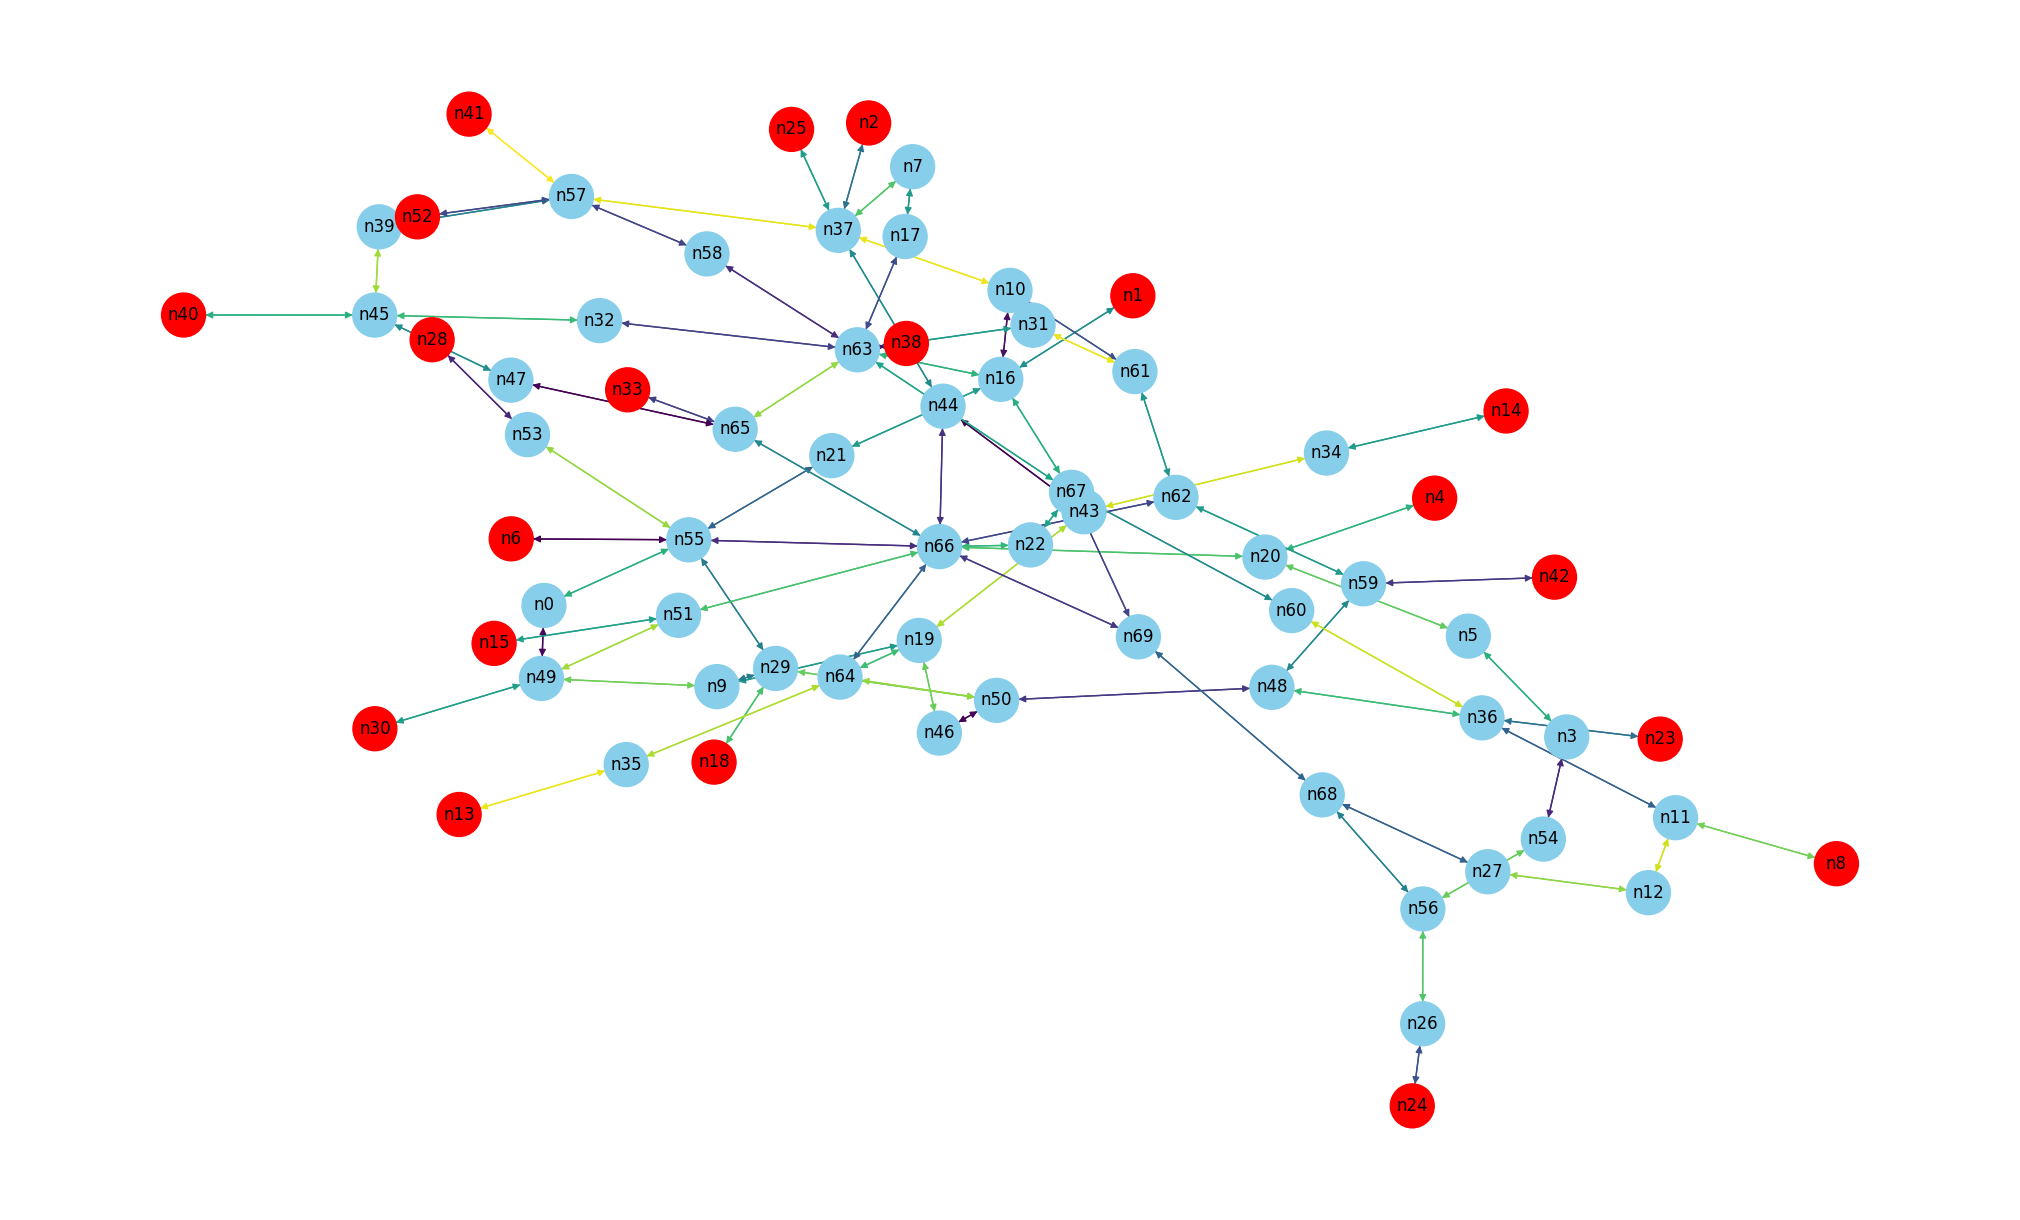

In [12]:
#plot the graph, coloring the edges based on the traffic
plt.figure(figsize=(20,12))
nx.draw(G2, with_labels=True, node_size=1000, node_shape="o", edge_color=[G2.edges[edge]['traffic'] for edge in G2.edges], node_color=np.where(list(nx.get_node_attributes(G2, 'border').values()), 'r', 'skyblue'))

In [13]:
#save the graph
with open('graph2.gpickle', 'wb') as f:
    pickle.dump(G, f)